# Utilities and Pre-processing

#### Imports

In [65]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, Concatenate, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM,Bidirectional
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
import re
from nltk.stem.porter import PorterStemmer
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

PADDED_SENTENCE_LENGTH = 50
VOCAB_SIZE = 10000
BATCH_SIZE = 16

ps = PorterStemmer()

[nltk_data] Downloading package stopwords to /Users/byuu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Functions

In [80]:

def preprocess_text(df_column):
    corpus = []
    for i in range(0, len(df_column)):
        
        text = re.sub('[^a-zA-Z]', ' ', df_column.iloc[i])
        text = re.sub(r'@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+', ' ', str(text).lower()).strip()
        text = re.sub(r'\d+', 'digit', text)

        text = text.split()
        
        # if a word is not in Stop Words,then only we will add it to review (list/array)
        text = [ps.stem(word) for word in text if not word in stopwords.words('english')]
        text = ' '.join(text)
        corpus.append(text)

    return corpus

# Splits the dataset into x_train, x_test, y_train, y_test
def split_dataset(X, y ,test_size = 0.2, random_state = 42):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1, random_state=random_state)
    return X_train, X_test, y_train, y_test, X_validation, y_validation

# Plots the training and validation accuracies across the epochs
def plot_training_and_validation_accuracies(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='right')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='right')

    plt.show()

def build_model(PADDED_SENTENCE_LENGTH, VOCAB_SIZE):

    embedding_vector_features = 100
    l2_lambda = 0.001  # Regularization factor

    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, embedding_vector_features, input_length=PADDED_SENTENCE_LENGTH,
                        embeddings_regularizer=regularizers.l2(l2_lambda)))  # L2 regularization
    model.add(Bidirectional(LSTM(200, kernel_regularizer=regularizers.l2(l2_lambda))))  # L2 regularization on LSTM
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(l2_lambda)))  # L2 on Dense layer

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

def build_stacked_lstm_model(PADDED_SENTENCE_LENGTH, VOCAB_SIZE):
    embedding_vector_features = 100
    l2_lambda = 0.001  # Regularization factor
    
    model=Sequential()
    model.add(Embedding(VOCAB_SIZE, embedding_vector_features, input_length=PADDED_SENTENCE_LENGTH))
    model.add(LSTM(100,return_sequences=True, kernel_regularizer=regularizers.l2(l2_lambda))) 
    model.add(Dropout(0.2))

    model.add(LSTM(50,return_sequences=True, kernel_regularizer=regularizers.l2(l2_lambda))) 
    model.add(Dropout(0.1))

    model.add(LSTM(20, kernel_regularizer=regularizers.l2(l2_lambda))) 
    model.add(Dropout(0.2))

    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    print(model.summary())

    return model



# Plot a confusion matrix
def print_confusion_matrix(model, label_encoder, text, labels):
    
    # Predict
    predictions = model.predict(text, steps=BATCH_SIZE)
    predicted_classes = (predictions > 0.5).astype(int)

    if label_encoder != None:
        # Decode the encoded labels back to their original class names
        decoded_predicted_classes = label_encoder.inverse_transform(predicted_classes)
        decoded_true_classes = label_encoder.inverse_transform(labels)
    else:
        decoded_predicted_classes = np.where(predicted_classes == 1, 'Real', 'Fake')
        decoded_true_classes = np.where(labels == 1, 'Real', 'Fake')
        
    # Compute the confusion matrix
    cm = confusion_matrix(decoded_true_classes, decoded_predicted_classes)

    # Print confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(decoded_true_classes), yticklabels=np.unique(decoded_true_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.gca().invert_xaxis() # Invert the x axis
    plt.show()

    # Print accuracy score
    accuracy = accuracy_score(decoded_true_classes, decoded_predicted_classes)
    print("Accuracy:", accuracy)

#### Import Dataset

In [4]:
# Load the datasets
fake_news_df = pd.read_csv(os.path.expanduser('/Users/byuu/Desktop/Kaggle Fake News/WELFake_Dataset.csv'))
fake_news_df = fake_news_df.dropna()
print(fake_news_df.isnull().sum())

sentiment_analysis_df = pd.read_csv(os.path.expanduser('/Users/byuu/Desktop/Natural Language Processing/Assignment 3/Code/Datasets/Sentiment Analysis Dataset.csv'), encoding_errors='ignore')
sentiment_analysis_df = sentiment_analysis_df.dropna()
print(sentiment_analysis_df.isnull().sum())

# Transform the target classes into 0 and 1
label_encoder = LabelEncoder()
encoded_sentiment_labels = label_encoder.fit_transform(sentiment_analysis_df['target'])
encoded_fake_news_labels = fake_news_df['label'] # No need to transform, 1 is real news, 0 is fake news

# Apply preprocess_text function to DataFrame
fake_news_corpus = preprocess_text(fake_news_df['title'])
sentiment_analysis_corpus = preprocess_text(sentiment_analysis_df['text'])

sentiment_analysis_max_length = max(len(sentence.split()) for sentence in sentiment_analysis_corpus)
fake_news_max_length = max(len(sentence.split()) for sentence in fake_news_corpus)

print("Sentiment analysis maximum sentence length:", sentiment_analysis_max_length)
print("Fake news maximum sentence length:", fake_news_max_length)

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64
target    0
text      0
dtype: int64
Sentiment analysis maximum sentence length: 41
Fake news maximum sentence length: 47


#### One hot encode and pad the sentences

In [5]:
# Retrieve a list of lists, where the inner list contains each word's index corresponding to where the "1" is in the one hot encoded.
onehot_fake_news=[one_hot(words,VOCAB_SIZE) for words in fake_news_corpus] 
onehot_sentiment_analysis=[one_hot(words,VOCAB_SIZE) for words in sentiment_analysis_corpus] 

# Adding padding to sentences so that all sentences are of same length i.e 50, to avoid varying input sizes
padded_embedded_sentiment_analysis = pad_sequences(onehot_sentiment_analysis,padding='pre',maxlen=PADDED_SENTENCE_LENGTH)
padded_embedded_fake_news = pad_sequences(onehot_fake_news,padding='pre',maxlen=PADDED_SENTENCE_LENGTH)

# Evaluate Fake News Detection Without Sentiment Analysis

In [53]:
embedding_vector_features = 100

# Input for textual data
text_input = Input(shape=(PADDED_SENTENCE_LENGTH,), dtype='int32', name='text_input')

# Embedding layer
x = Embedding(VOCAB_SIZE, embedding_vector_features, input_length=PADDED_SENTENCE_LENGTH)(text_input)

# LSTM layers
x = LSTM(100, return_sequences=True)(x)
x = Dropout(0.2)(x)
x = LSTM(50, return_sequences=True)(x)
x = Dropout(0.1)(x)
x = LSTM(20)(x)  # Last LSTM layer, outputs will be concatenated with the sentiment model output
x = Dropout(0.1)(x)

# Output layer
output = Dense(1, activation='sigmoid')(x)

# Create model
model = Model(inputs=text_input, outputs=output)
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

/opt/anaconda3/envs/python10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


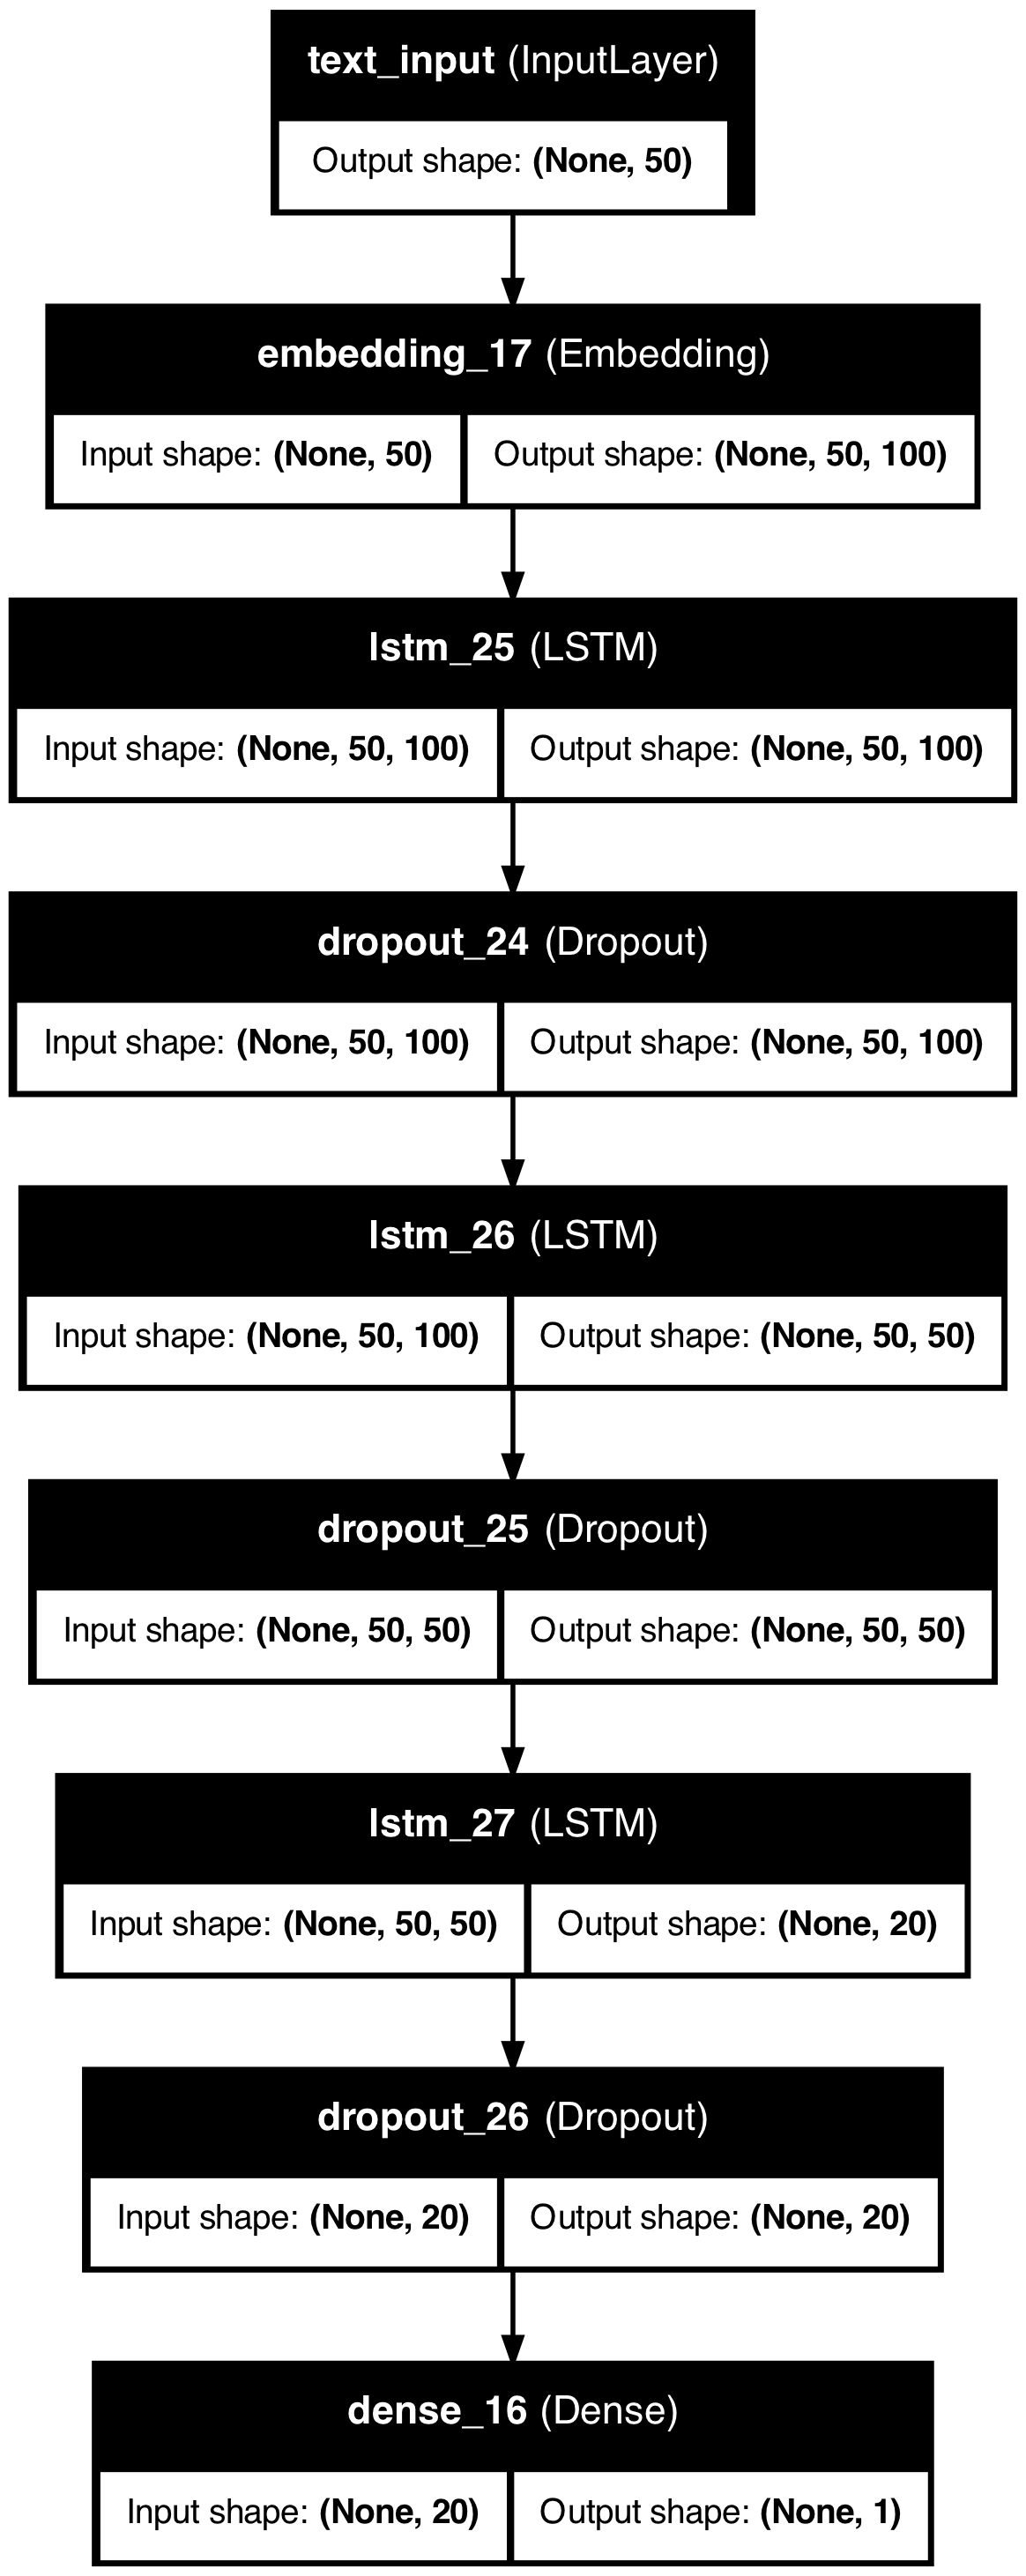

In [63]:
plot_model(model, to_file='Fake News WITHOUT SA.png', show_shapes=True, show_layer_names=True)

In [61]:
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_17 (Embedding)        │ (None, 50, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 50, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 50, 50)         │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 20)             │         5,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,348,905 (12.78 MB)

 Trainable params: 1,116,301 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,232,604 (8.52 MB)

#### Split Fake News Dataset

In [54]:
X_train_fn, X_test_fn, y_train_fn, y_test_fn, X_validation_fn, y_validation_fn = split_dataset(padded_embedded_fake_news, encoded_fake_news_labels,test_size = 0.2, random_state = 42)

#### Train Fake News Classifier Without Sentiment Analysis Feature Extractor

In [55]:
checkpoint = ModelCheckpoint(
    "/Users/byuu/Desktop/Kaggle Fake News/Fake News Without SA Weights/weights.{epoch:02d}-{val_loss:.2f}.weights.h5", 
    monitor = 'val_loss', 
    save_best_only = True, 
    verbose = 1, 
    save_freq = 'epoch',
    save_weights_only = True
)

# Training
history = model.fit(X_train_fn, y_train_fn,
          validation_data=(X_test_fn, y_test_fn),
          epochs=50,
          batch_size=BATCH_SIZE,
          callbacks=[checkpoint])

Epoch 1/50
3219/3220 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8320 - loss: 0.3519
Epoch 1: val_loss improved from inf to 0.23489, saving model to /Users/byuu/Desktop/Kaggle Fake News/Fake News Without SA Weights/weights.01-0.23.weights.h5
3220/3220 ━━━━━━━━━━━━━━━━━━━━ 120s 37ms/step - accuracy: 0.8320 - loss: 0.3519 - val_accuracy: 0.9054 - val_loss: 0.2349
Epoch 2/50
3220/3220 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9297 - loss: 0.1815
Epoch 2: val_loss improved from 0.23489 to 0.23091, saving model to /Users/byuu/Desktop/Kaggle Fake News/Fake News Without SA Weights/weights.02-0.23.weights.h5
3220/3220 ━━━━━━━━━━━━━━━━━━━━ 117s 36ms/step - accuracy: 0.9297 - loss: 0.1815 - val_accuracy: 0.9063 - val_loss: 0.2309
Epoch 3/50
3220/3220 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9490 - loss: 0.1340
Epoch 3: val_loss did not improve from 0.23091
3220/3220 ━━━━━━━━━━━━━━━━━━━━ 117s 36ms/step - accuracy: 0.9490 - loss: 0.1340 - val_accuracy: 0.8987 - val_loss: 0.2637
Ep

#### Plot Training and Validation Accuracy

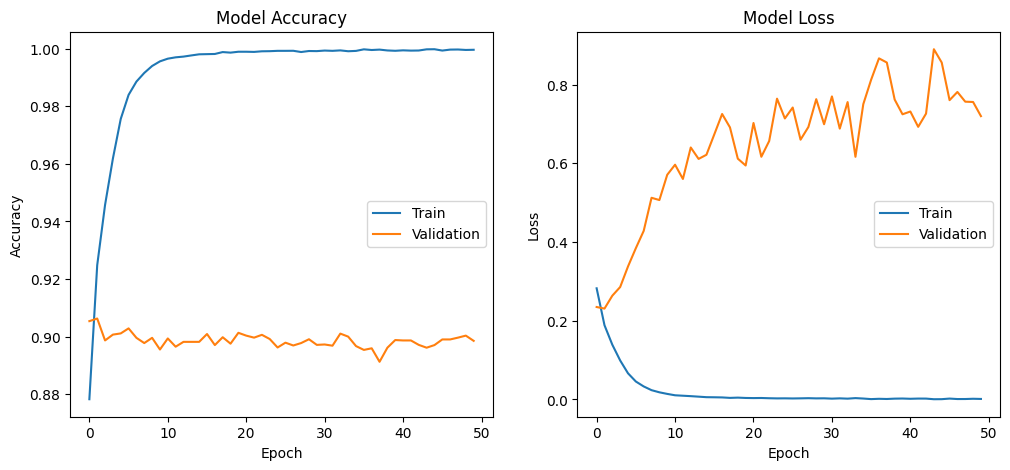

In [56]:
plot_training_and_validation_accuracies(history)

#### Print Confusion Matrix Using Best Weight

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step


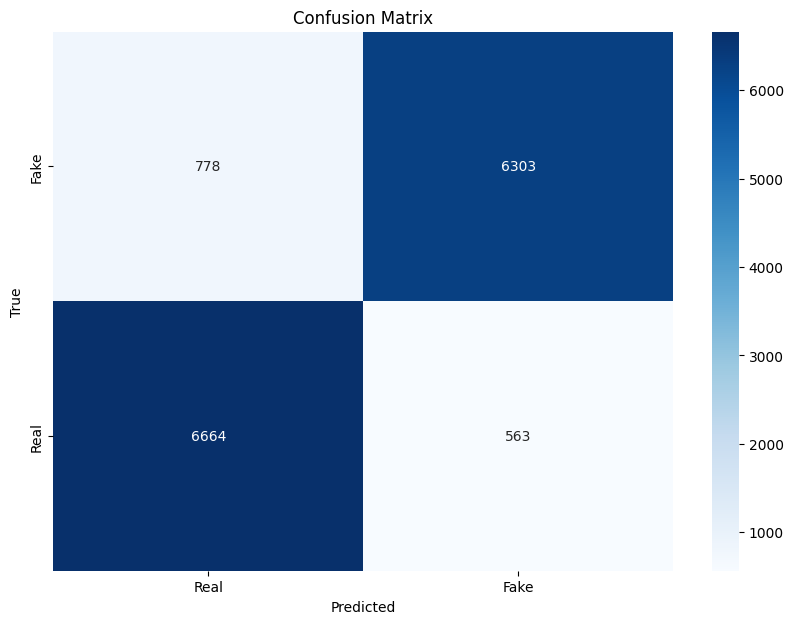

Accuracy: 0.9062762091137825


In [60]:
model.load_weights('/Users/byuu/Desktop/Kaggle Fake News/Fake News Without SA Weights/weights.02-0.23.weights.h5')

print_confusion_matrix(model, None, X_test_fn, y_test_fn)

# Evaluate Fake News Detection With Sentiment Analysis

### Train Sentiment Analysis Model

In [67]:
X_train, X_test, y_train, y_test, X_validation, y_validation = split_dataset(padded_embedded_sentiment_analysis, encoded_sentiment_labels,test_size = 0.2, random_state = 42)

#### Experiment with simple LSTM

In [78]:
checkpoint = ModelCheckpoint(
    "/Users/byuu/Desktop/Kaggle Fake News/Simple Sentiment Analysis Weights/weights.{epoch:02d}-{val_loss:.2f}.weights.h5", 
    monitor = 'val_loss', 
    save_best_only = True, 
    verbose = 1, 
    save_freq = 'epoch',
    save_weights_only = True
)

model = build_model(PADDED_SENTENCE_LENGTH, VOCAB_SIZE)

# Training
history = model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=50,
          batch_size=BATCH_SIZE,
          callbacks=[checkpoint])

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_23 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6387 - loss: 0.8376
Epoch 1: val_loss improved from inf to 0.60261, saving model to /Users/byuu/Desktop/Kaggle Fake News/Simple Sentiment Analysis Weights/weights.01-0.60.weights.h5
481/481 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - accuracy: 0.6389 - loss: 0.8373 - val_accuracy: 0.7605 - val_loss: 0.6026
Epoch 2/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8016 - loss: 0.5472
Epoch 2: val_loss improved from 0.60261 to 0.59528, saving model to /Users/byuu/Desktop/Kaggle Fake News/Simple Sentiment Analysis Weights/weights.02-0.60.weights.h5
481/481 ━━━━━━━━━━━━━━━━━━━━ 41s 84ms/step - accuracy: 0.8016 - loss: 0.5472 - val_accuracy: 0.7633 - val_loss: 0.5953
Epoch 3/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8183 - loss: 0.5053
Epoch 3: val_loss improved from 0.59528 to 0.57390, saving model to /Users/byuu/Desktop/Kaggle Fake News/Simple Sentiment Analysis Weights/weights.03-0.57.weights.h5
48

In [77]:
plot_model(model, to_file='Simple Sentiment Analysis.png', show_shapes=True, show_layer_names=True)

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

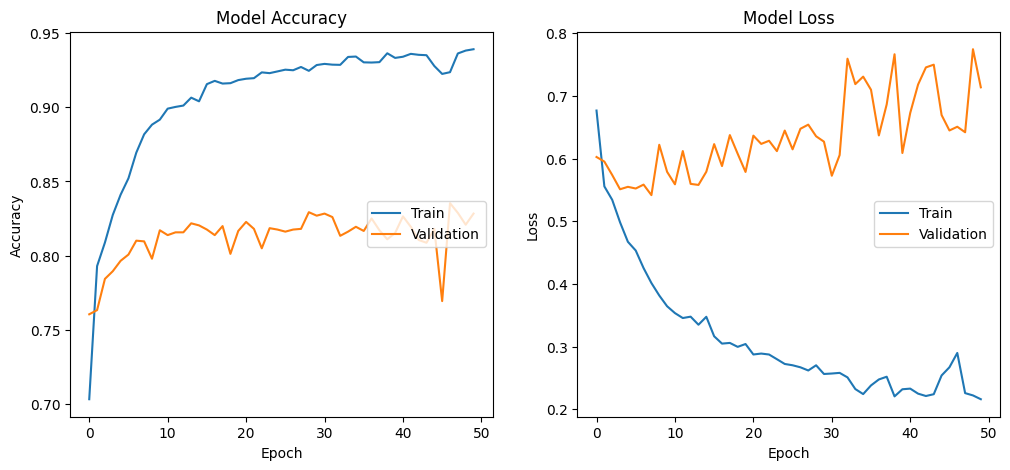

In [79]:
# Plot training and validation accuracy
plot_training_and_validation_accuracies(history)

#### Test using best weight for simple LSTM model

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


/opt/anaconda3/envs/python10/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


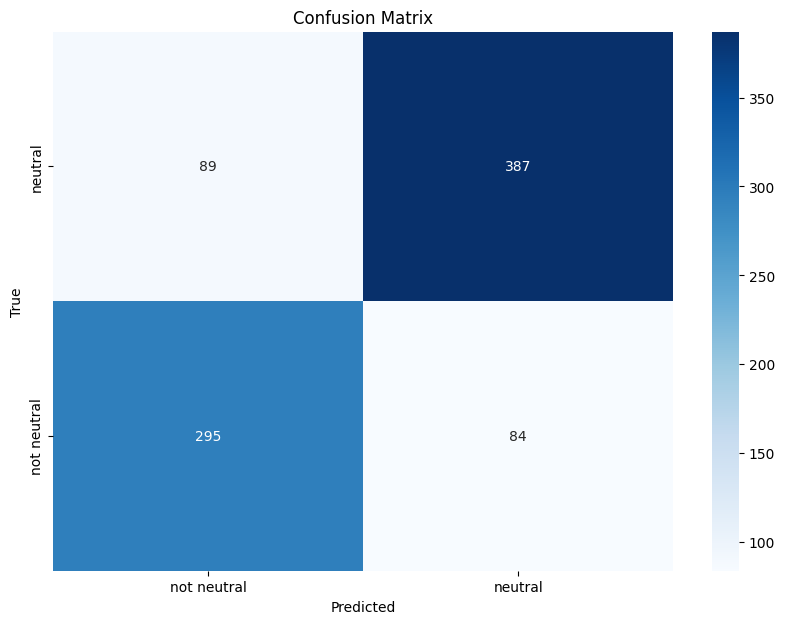

Accuracy: 0.7976608187134503


In [88]:
# Load weights
model.load_weights('/Users/byuu/Desktop/Kaggle Fake News/Simple Sentiment Analysis Weights/weights.08-0.54.weights.h5')

# Print confusion matrix
print_confusion_matrix(model, label_encoder, X_validation, y_validation)

#### Experiment with stacked LSTM

In [81]:
checkpoint = ModelCheckpoint(
    "/Users/byuu/Desktop/Kaggle Fake News/Stacked Sentiment Analysis Weights/weights.{epoch:02d}-{val_loss:.2f}.weights.h5", 
    monitor = 'val_loss', 
    save_best_only = True, 
    verbose = 1, 
    save_freq = 'epoch',
    save_weights_only = True
)

stacked_model = build_stacked_lstm_model(PADDED_SENTENCE_LENGTH, VOCAB_SIZE)

# Training
history = stacked_model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=50,
          batch_size=BATCH_SIZE,
          callbacks=[checkpoint])

/opt/anaconda3/envs/python10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_24 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6503 - loss: 0.7246
Epoch 1: val_loss improved from inf to 0.50430, saving model to /Users/byuu/Desktop/Kaggle Fake News/Stacked Sentiment Analysis Weights/weights.01-0.50.weights.h5
481/481 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.6505 - loss: 0.7244 - val_accuracy: 0.7689 - val_loss: 0.5043
Epoch 2/50
480/481 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8443 - loss: 0.3922
Epoch 2: val_loss improved from 0.50430 to 0.46970, saving model to /Users/byuu/Desktop/Kaggle Fake News/Stacked Sentiment Analysis Weights/weights.02-0.47.weights.h5
481/481 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.8443 - loss: 0.3923 - val_accuracy: 0.7919 - val_loss: 0.4697
Epoch 3/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8839 - loss: 0.3201
Epoch 3: val_loss did not improve from 0.46970
481/481 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.8839 - loss: 0.3201 - val_accuracy: 0.8134 - val_loss: 0.4762


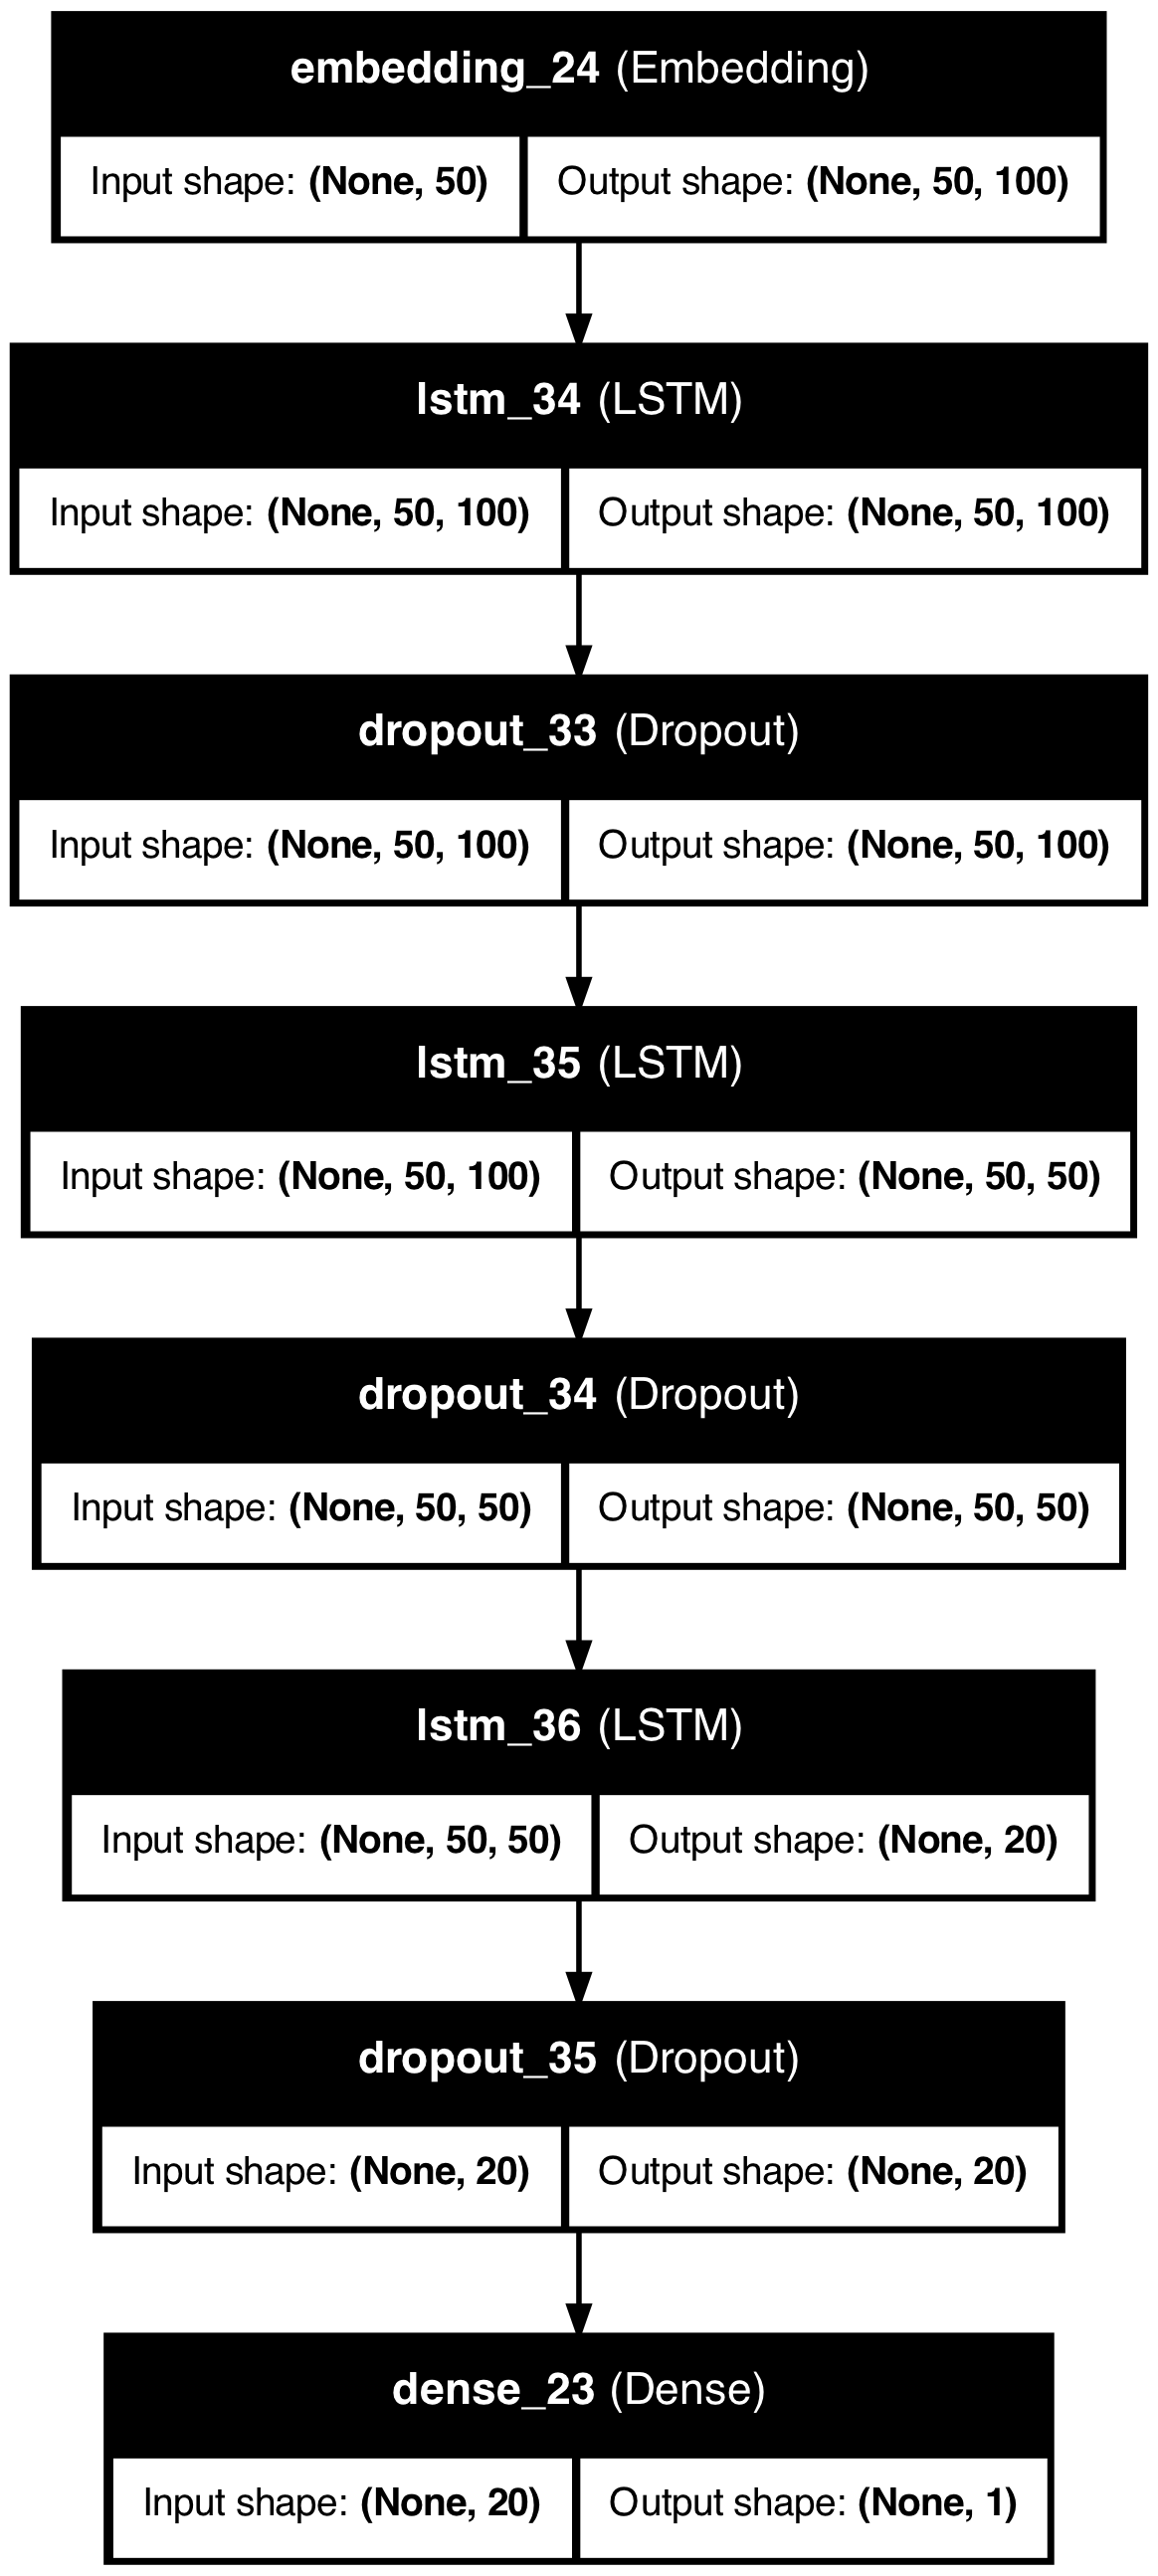

In [87]:
plot_model(stacked_model, to_file='Stacked Sentiment Analysis.png', show_shapes=True, show_layer_names=True)

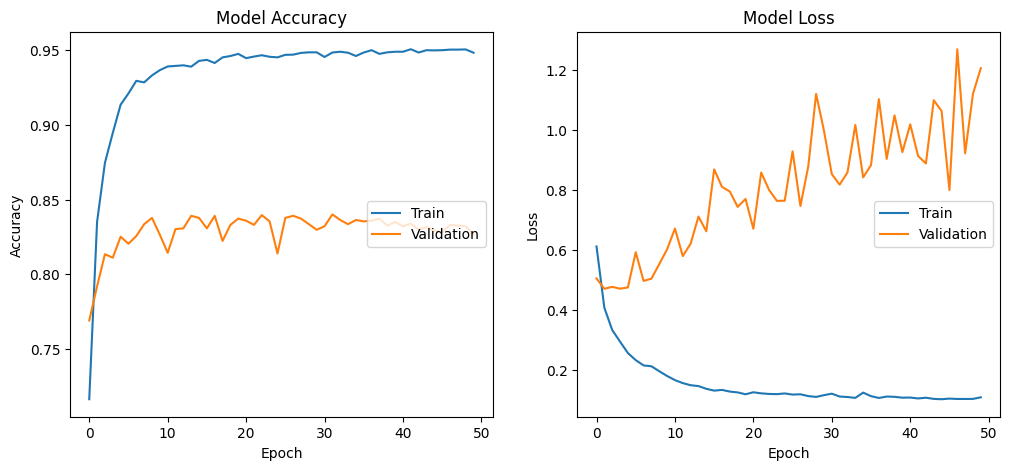

In [83]:
# Plot training and validation accuracy
plot_training_and_validation_accuracies(history)

#### Test using best weight for stacked LSTM model

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


/opt/anaconda3/envs/python10/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


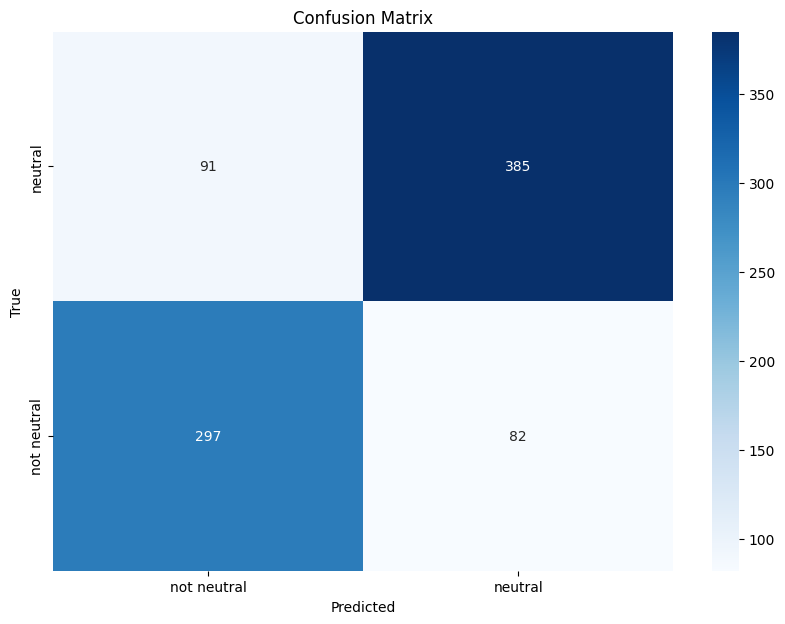

Accuracy: 0.7976608187134503


In [90]:
# Load weights
stacked_model.load_weights('/Users/byuu/Desktop/Kaggle Fake News/Stacked Sentiment Analysis Weights/weights.02-0.47.weights.h5')

# Print confusion matrix
print_confusion_matrix(stacked_model, label_encoder, X_validation, y_validation)

### Train Fake News Classifier Using Best Sentiment Analysis Model as Feature Extractor

#### Use stacked Best Sentiment Analysis model for feature extraction
* Stacked model and simply model have the same testing accuracy, and the confusion matrices are pretty equal. 
* Hence, choose to use the stacked model because it has more parameters, it could extract more features from the fake news text

In [91]:
# Observe the model architecture to determine layers to input and output as feature extractor.
stacked_model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_24 (Embedding)        │ (None, 50, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 50, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 50, 50)         │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 20)             │         5,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,348,905 (12.78 MB)

 Trainable params: 1,116,301 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,232,604 (8.52 MB)

In [92]:
# Create a feature extractor from the sentiment analysis model, remove the last layer
sentiment_feature_extractor = Model(inputs=stacked_model.get_layer('embedding_24').input, # Input of the feature extractor is the same as the stacked model's input
                                    outputs=stacked_model.get_layer('dropout_35').output)  # Output of the feature extractor is the same as the stacked model's layer before classification

# Freeze training, so that the model acts purely as a feature extractor
for layer in sentiment_feature_extractor.layers:
    layer.trainable = False

In [96]:
embedding_vector_features = 100

# Input for textual data
text_input = Input(shape=(PADDED_SENTENCE_LENGTH,), dtype='int32', name='text_input')

# Embedding layer
x = Embedding(VOCAB_SIZE, embedding_vector_features, input_length=PADDED_SENTENCE_LENGTH)(text_input)

# LSTM layers
x = LSTM(100, return_sequences=True)(x)
x = Dropout(0.2)(x)
x = LSTM(50, return_sequences=True)(x)
x = Dropout(0.1)(x)
x = LSTM(20)(x)  # Last LSTM layer, outputs will be concatenated with additional features
x = Dropout(0.1)(x)

# Use sentiment model to process the same text input
sentiment_output = sentiment_feature_extractor(text_input)

# Concatenating the output of the last LSTM with the sentiment model output and additional features
x = Concatenate()([x, sentiment_output])

# Output layer
output = Dense(1, activation='sigmoid')(x)

# Create model
model = Model(inputs=[text_input], outputs=output)
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

model.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_26        │ (None, 50, 100)   │  1,000,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_40 (LSTM)      │ (None, 50, 100)   │     80,400 │ embedding_26[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 50, 100)   │          0 │ lstm_40[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_41 (LSTM)      │ (None, 50, 50)    │     30,200 │ dropout_39[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 50, 50)    │          0 │ lstm_41[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_42 (LSTM)      │ (None, 20)        │      5,680 │ dropout_40[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, 20)        │          0 │ lstm_42[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_23       │ (None, 20)        │  1,116,280 │ text_input[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 40)        │          0 │ dropout_41[0][0], │
│ (Concatenate)       │                   │            │ functional_23[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 1)         │         41 │ concatenate_5[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,232,601 (8.52 MB)

 Trainable params: 1,116,321 (4.26 MB)

 Non-trainable params: 1,116,280 (4.26 MB)

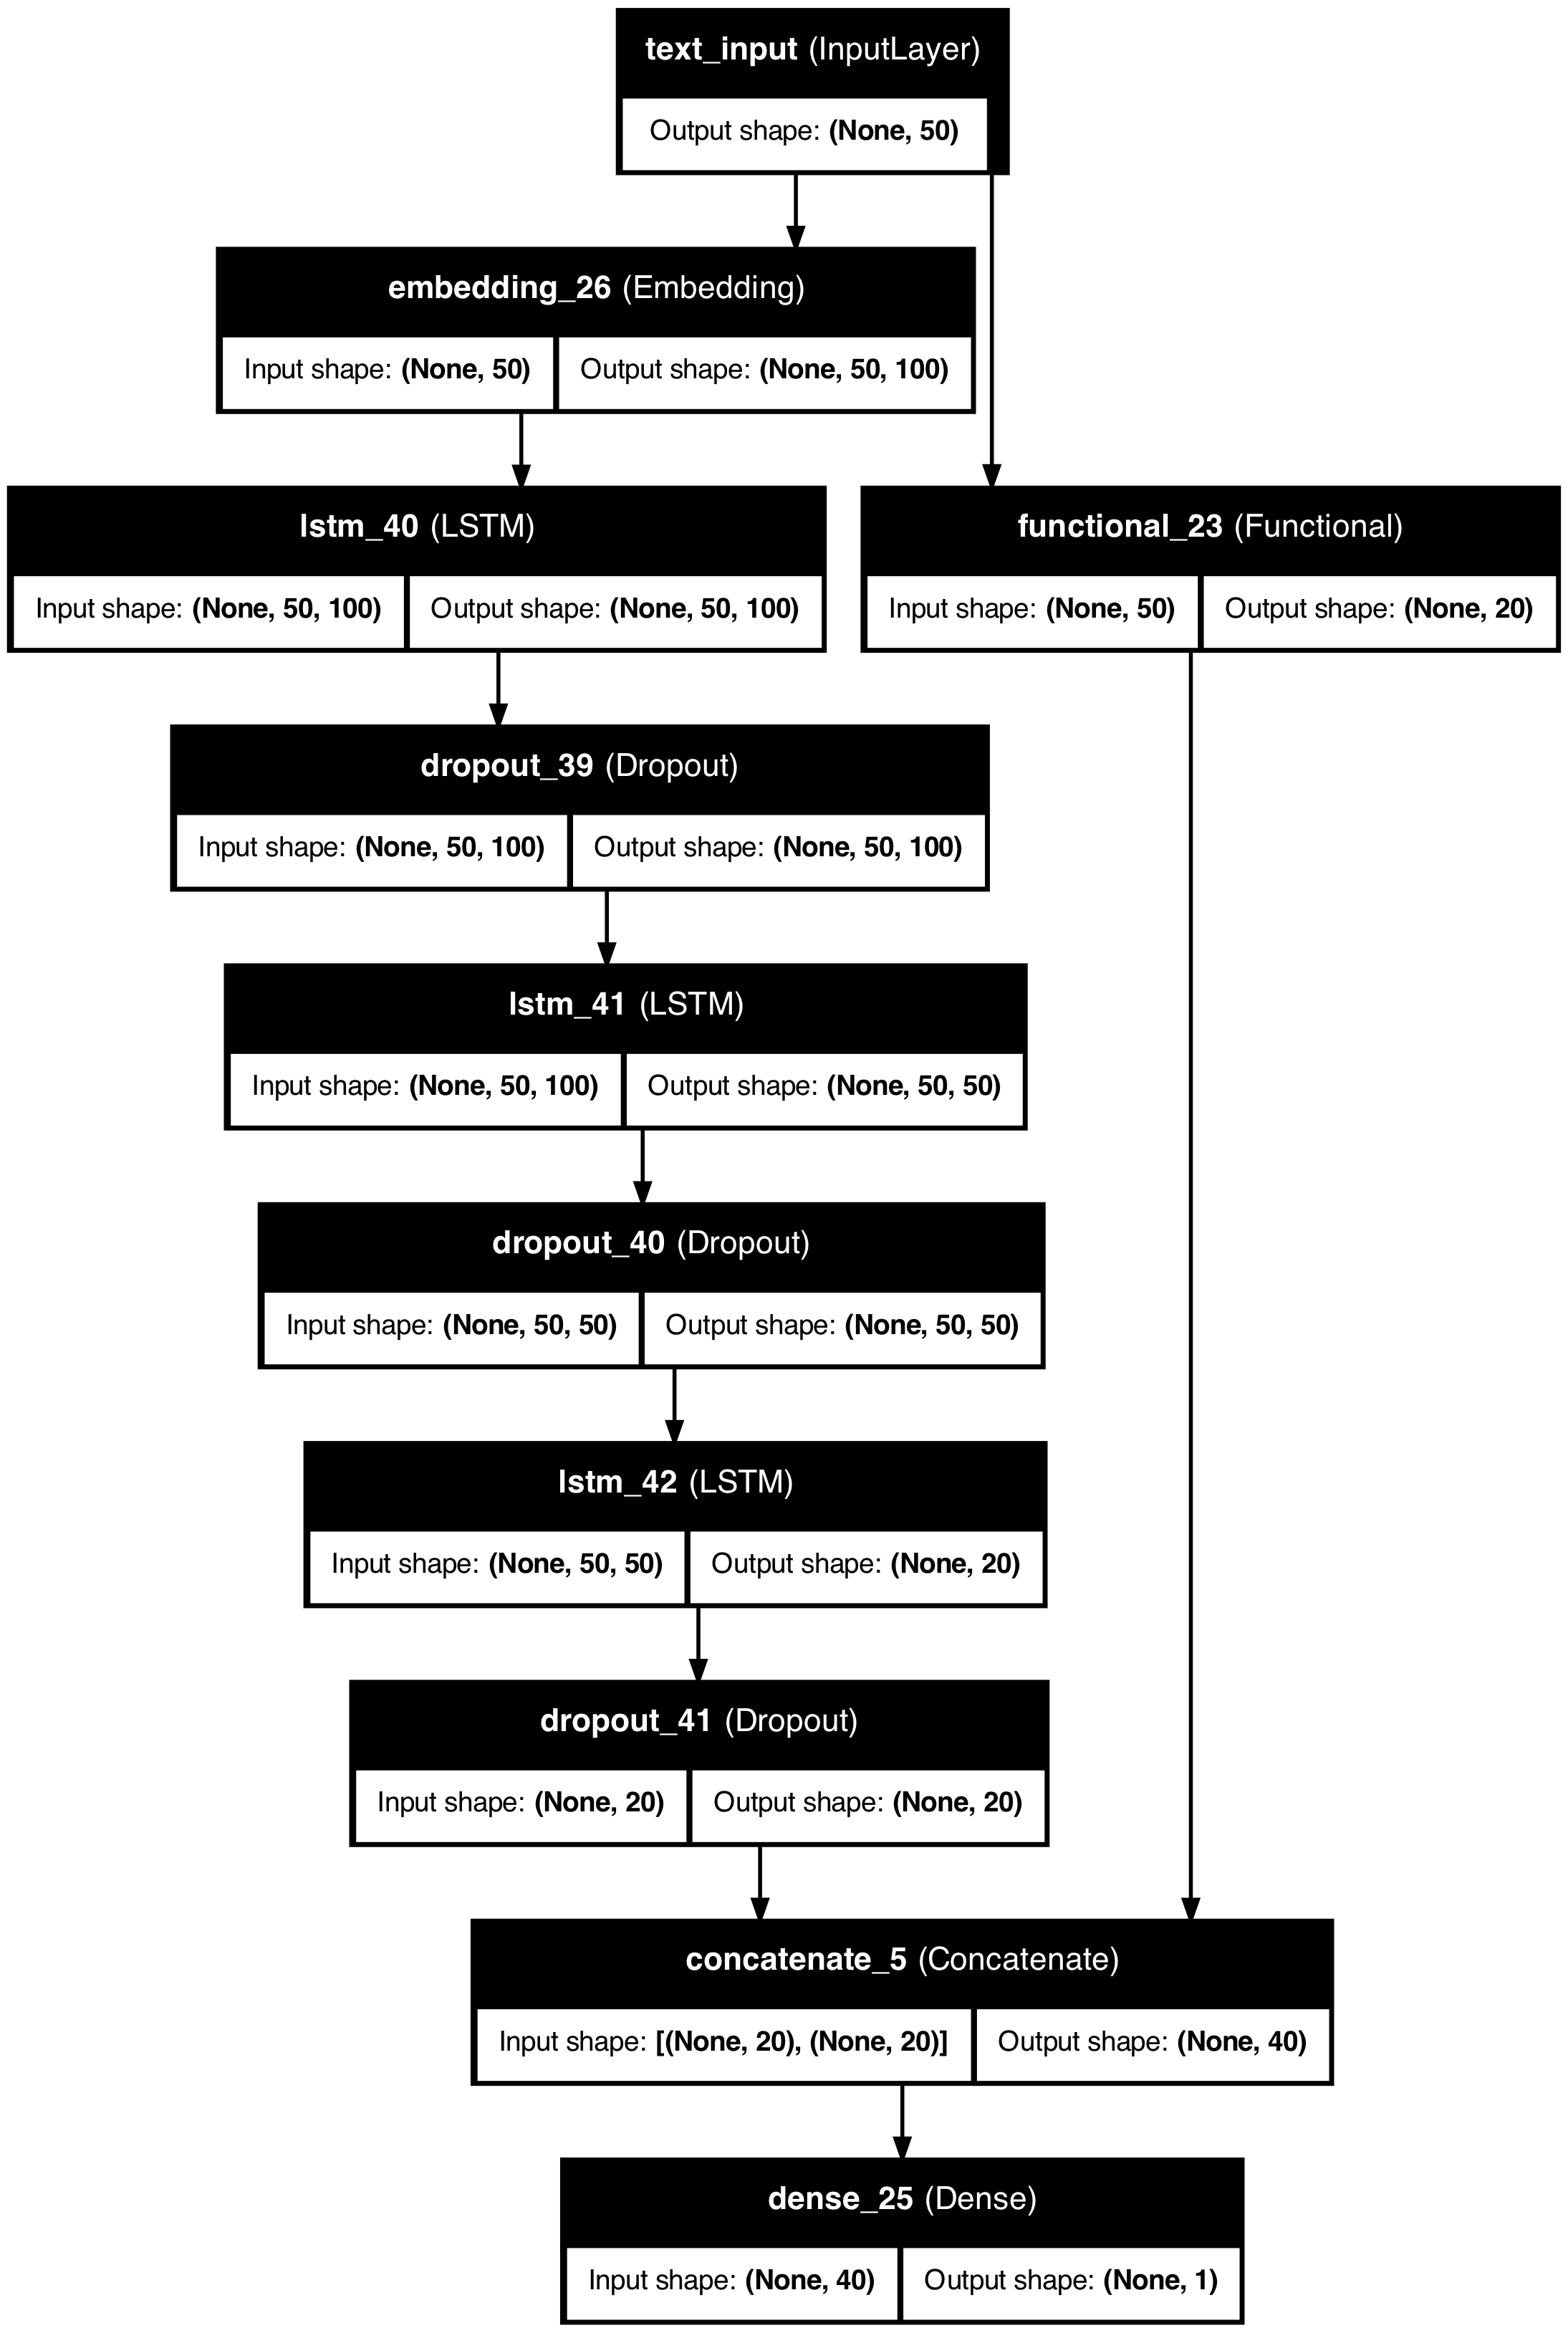

In [97]:
plot_model(model, to_file='Fake News WITH SA.png', show_shapes=True, show_layer_names=True)

#### Train the Model Created with Sentiment Analysis Feature Extraction

In [98]:
checkpoint = ModelCheckpoint(
    "/Users/byuu/Desktop/Kaggle Fake News/Fake News WITH SA Weights/weights.{epoch:02d}-{val_loss:.2f}.weights.h5", 
    monitor = 'val_loss', 
    save_best_only = True, 
    verbose = 1, 
    save_freq = 'epoch',
    save_weights_only = True
)

# Training
history = model.fit(X_train_fn, y_train_fn,
          validation_data=(X_test_fn, y_test_fn),
          epochs=50,
          batch_size=BATCH_SIZE,
          callbacks=[checkpoint])

Epoch 1/50
3219/3220 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8248 - loss: 0.3603
Epoch 1: val_loss improved from inf to 0.24906, saving model to /Users/byuu/Desktop/Kaggle Fake News/Fake News WITH SA Weights/weights.01-0.25.weights.h5
3220/3220 ━━━━━━━━━━━━━━━━━━━━ 156s 48ms/step - accuracy: 0.8249 - loss: 0.3602 - val_accuracy: 0.8954 - val_loss: 0.2491
Epoch 2/50
3220/3220 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9295 - loss: 0.1830
Epoch 2: val_loss improved from 0.24906 to 0.23704, saving model to /Users/byuu/Desktop/Kaggle Fake News/Fake News WITH SA Weights/weights.02-0.24.weights.h5
3220/3220 ━━━━━━━━━━━━━━━━━━━━ 156s 49ms/step - accuracy: 0.9295 - loss: 0.1830 - val_accuracy: 0.9026 - val_loss: 0.2370
Epoch 3/50
3219/3220 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9472 - loss: 0.1363
Epoch 3: val_loss did not improve from 0.23704
3220/3220 ━━━━━━━━━━━━━━━━━━━━ 154s 48ms/step - accuracy: 0.9472 - loss: 0.1363 - val_accuracy: 0.9072 - val_loss: 0.2524
Epoch 4/

#### Plot Training and Validation Accuracy

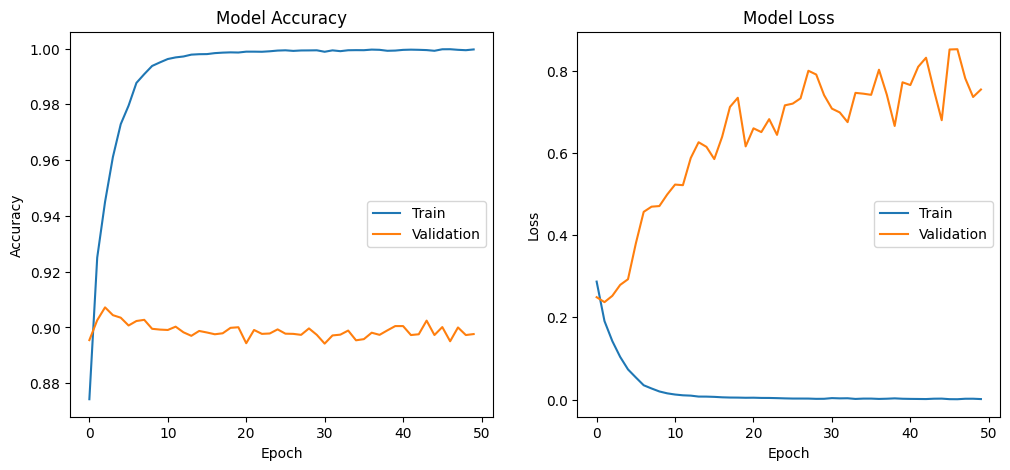

In [99]:
plot_training_and_validation_accuracies(history)

#### Print Confusion Matrix Using Best Weight

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step


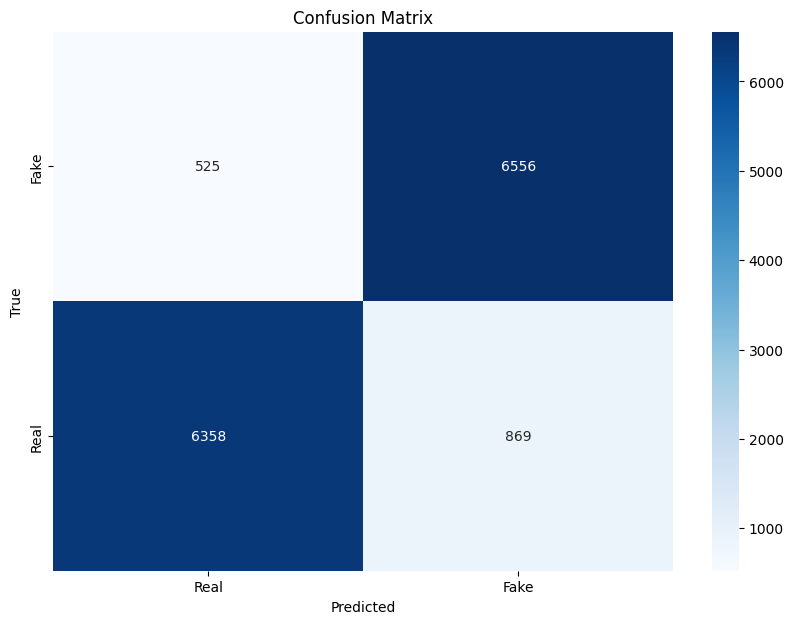

Accuracy: 0.9025719876991892


In [101]:
model.load_weights('/Users/byuu/Desktop/Kaggle Fake News/Fake News WITH SA Weights/weights.02-0.24.weights.h5')

print_confusion_matrix(model, None, X_test_fn, y_test_fn)